<h3>Assignment3</h3>
- 2017572003 Jaeyung Lee
- 2017572026 Juyeon Moon

In [49]:
# Load all library
import skvideo.io
import skvideo.datasets
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd

# Brightness signal computation

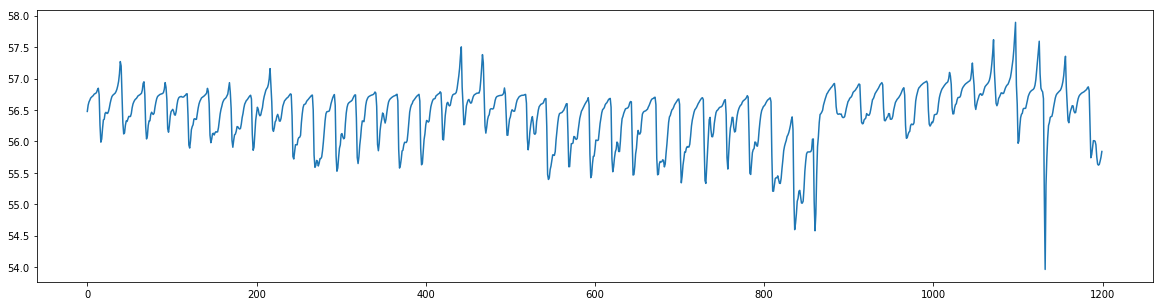

In [42]:
videodata = skvideo.io.vread("1.mp4", outputdict={"-pix_fmt": "gray"})
# print(videodata.shape)
brightness = np.zeros((len(videodata)))
for i in range(len(videodata)):
    frame = videodata[i]
    brightness[i] = sum(frame) / (frame.shape[0] * frame.shape[1])

'''
cutting
'''
brightness = brightness[-1200:]

plt.figure(figsize=(20,5))
plt.plot(list(range(len(brightness))), brightness)
plt.show()

# Band-pass filtering

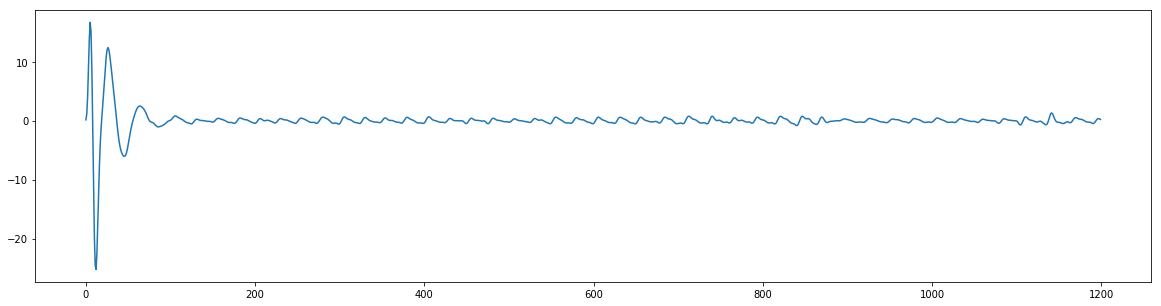

In [43]:
BPM_L = 45;    # Heart rate lower limit [bpm]
BPM_H = 200;   # Heart rate higher limit [bpm]
frame_rate = 30

# Butterworth frequencies must be in [0, 1], where 1 corresponds to half the sampling rate
b, a = signal.butter(4, [((BPM_L / 60) / frame_rate * 2), ((BPM_H / 60) / frame_rate * 2)], 'bandpass');
# print(b,a)
filter_bright = signal.lfilter(b, a, brightness)
plt.figure(figsize=(20,5))
plt.plot(list(range(len(filter_bright[:]))), filter_bright[:])
plt.show()

# Smoothing 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  


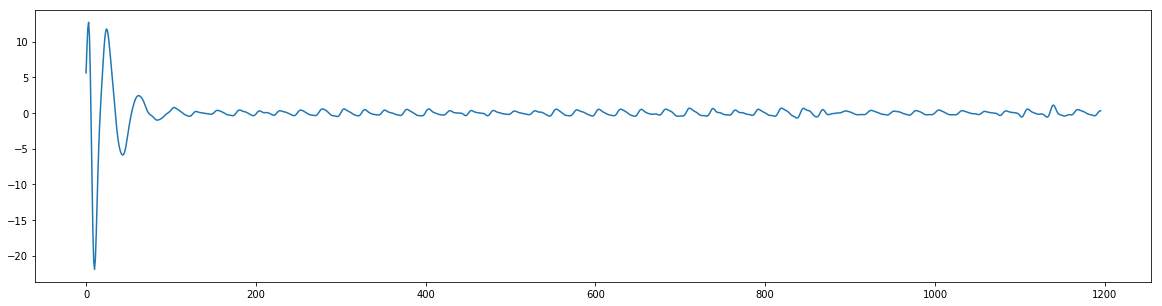

In [44]:
N = 5
smooth_signal = pd.rolling_mean(filter_bright, N)[N-1:]
plt.figure(figsize=(20,5))
plt.plot(list(range(len(smooth_signal[:]))), smooth_signal[:])
plt.show()
# print(smooth_signal)

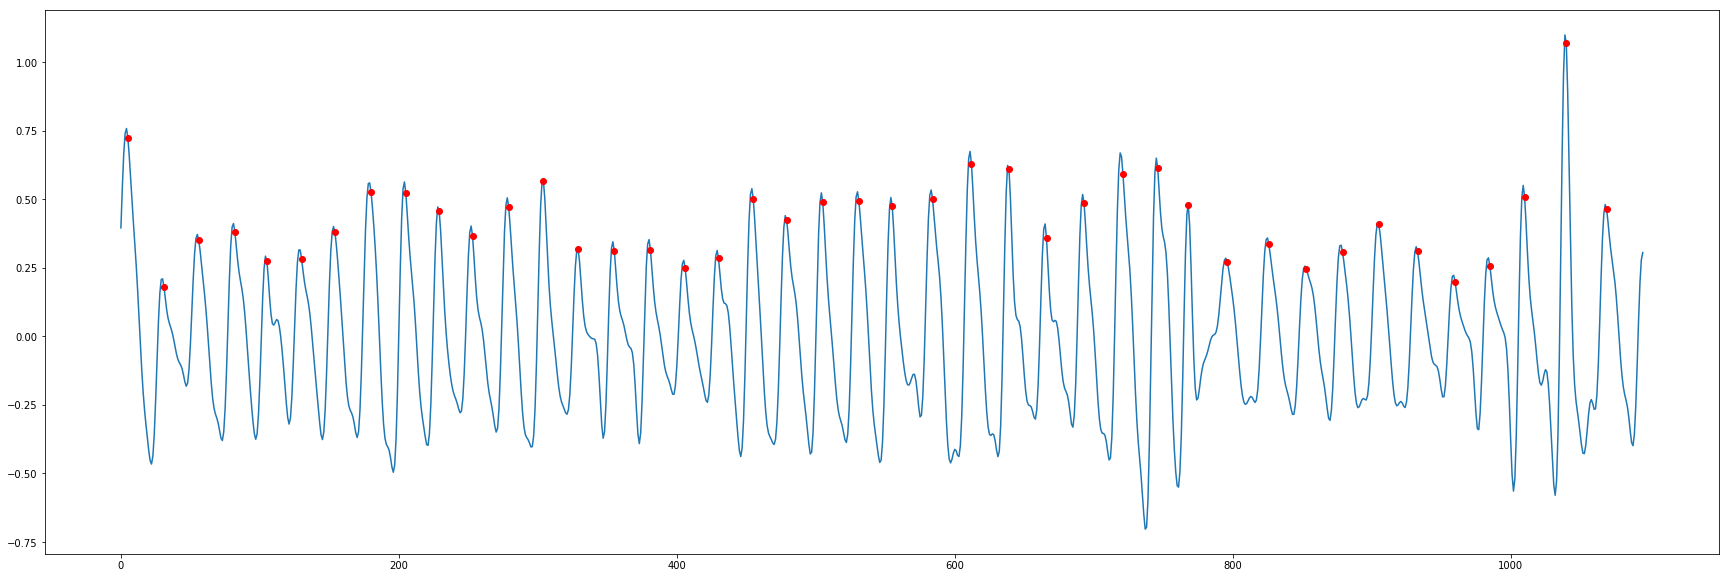

In [45]:
b_cutting = 100
peak = signal.find_peaks_cwt(smooth_signal[b_cutting:], np.arange(1,20))
peak_y = []

a_tck = smooth_signal[b_cutting:]
for i in peak:
    peak_y.append(a_tck[i])

plt.figure(figsize=(30,10))
plt.plot(list(range(len(smooth_signal[b_cutting:]))), smooth_signal[b_cutting:], peak, peak_y, 'ro')
plt.show()

# Upsampling & Interpolation

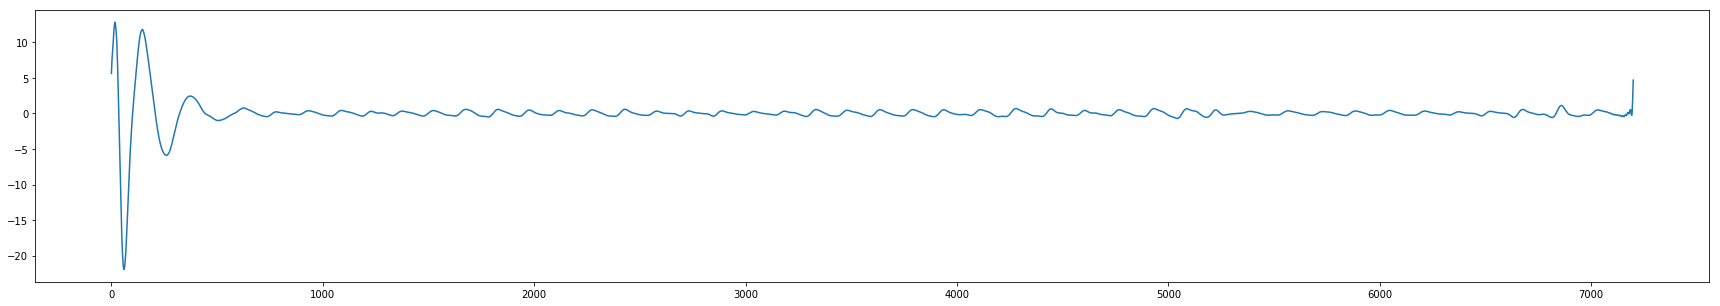

In [46]:
re_signal = signal.resample(smooth_signal, 1200 * 6)
plt.figure(figsize=(30,5))
plt.plot(list(range(len(re_signal[:]))), re_signal[:])
plt.show()

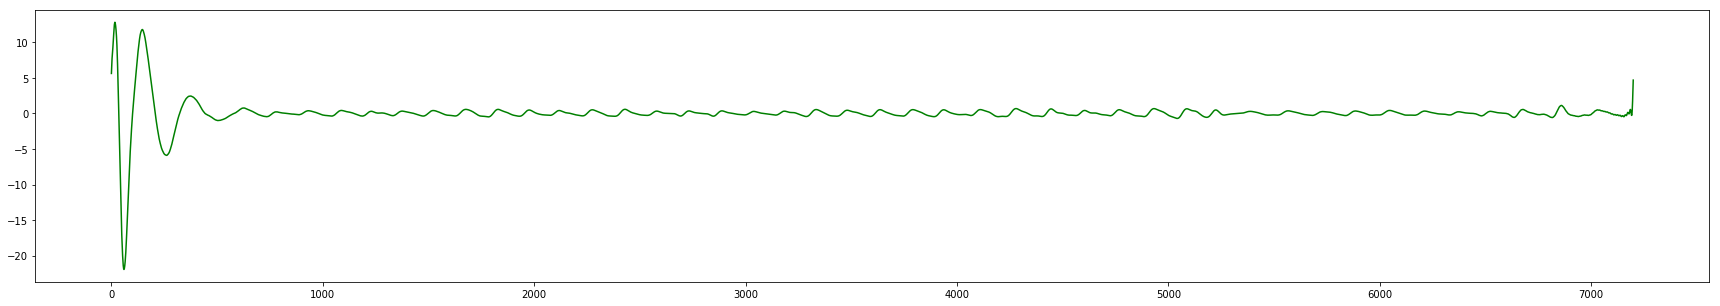

In [68]:
cubic = pd.Series(re_signal)
cubic.interpolate(method='cubic')

# print(len(cubic))
plt.figure(figsize=(30,5))
plt.plot(list(range(len(cubic))), cubic, 'g')
plt.show()


# Peak Detection

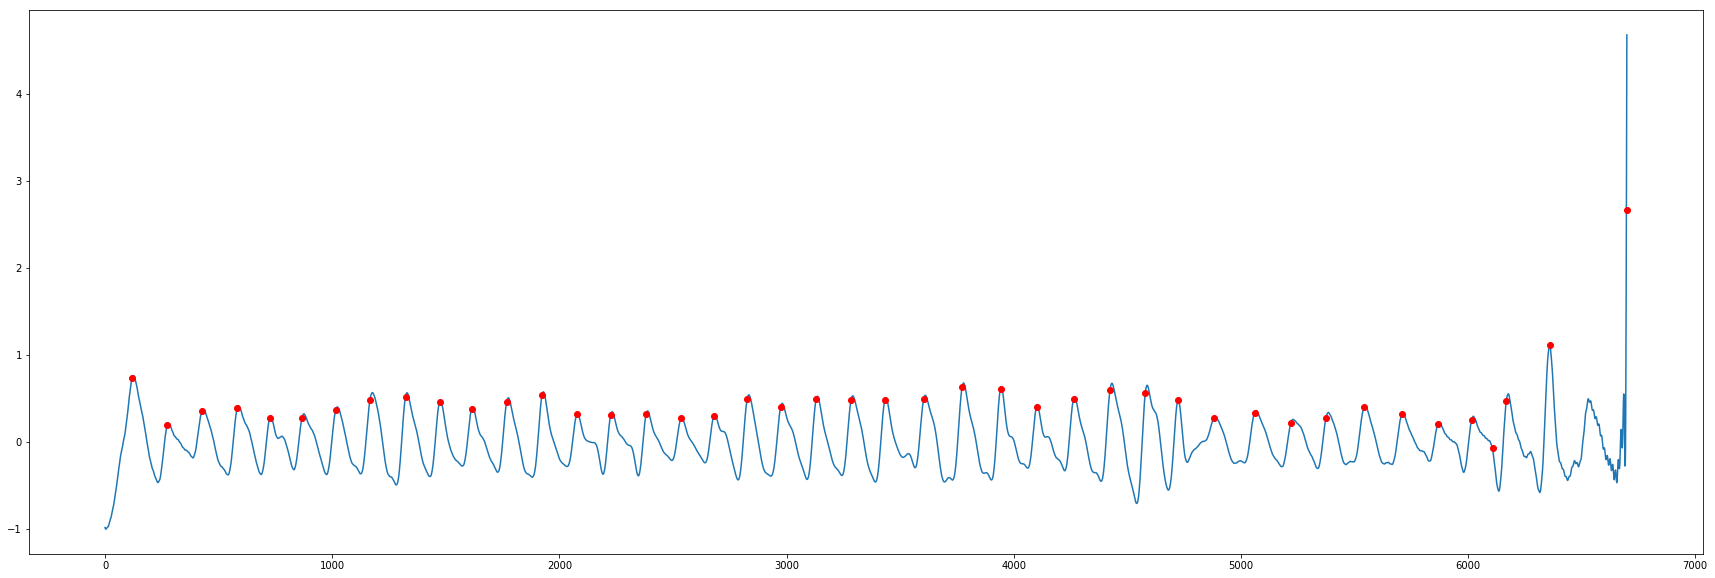

In [69]:
# print(len(tck[1][10:]))
cutting = 500
cubic = cubic[cutting:]
peak = signal.find_peaks_cwt(cubic, np.arange(1,100))
peak_y = []
# print(a_tck)
for i in peak:
    peak_y.append(cubic[i+499])

plt.figure(figsize=(30,10))
plt.plot(list(range(len(cubic))), cubic, peak, peak_y, 'ro')
plt.show()